# Gene Prediction Pipeline

## Introduction

This project was based on the 2008 paper ['Gene prediction in metagenomic fragments: A large scale machine learning approach'](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-217) by Hoff et at. The goal of this notebook is to train the gene prediction algorithm using a 2-stage approach - linear discriminant and neural network. The linear discriminant model reduces high dimensional features and the neural network predicts if a given sequence is a gene or not. My intentions for starting this project were to gain a deeper understanding of machine learning approaches behind the `Orphelia gene prediction algorithm` and sharpen my programming skills. 

Useful notebooks/files:
* `Sampling True NCS Dataset.ipynb` to see how NCS are sampled,
* `./modules` folder to see documentation on all methods,
* `./examples` folder for example code.

## Google Colab Setup

First clone the `gene-prediction` repository to Google Colab (see setup in `README.md`). Then install dependencies (see code below).

In [ ]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/My Drive/

# # Clone github repo
# !git clone https://github.com/viggy-ravi/gene-prediction.git

# # Change to project directory
# %cd gdrive/My Drive/gene-prediction

# # Install dependencies
# !pip install -r requirements.txt

# # Install biopython library manually
# !pip3 install biopython

# # Pull latest code
# !git pull

# Training Binary Classification Model

In [19]:
# Enter your email for the Entrez API 
email = "vignesh.ravindranath@gmail.com"

import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import Entrez
Entrez.email = email

# will inform your notebook to actively reload all 
# imported modules and packages as they are modified
%load_ext autoreload
%autoreload 2

# self defined modules
from modules import preprocess, extract, train, genepred, predict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocess Genome

Preprocessing a genome consists of finding all valid open reading frames (ORFs). ORFs start with a start codon (ATG, CTG, GTG, or TGT) and end with an in-frame stop codon (TAG, TGA, or TAA). To train our neural network, we need to find positive ORFs - sequencies that code for a protein (i.e. genes) -  and negative ORFs - sequencies in the genome that start with a start codon and end with an in-frame stop codon, but don't code for a protein. The negative ORFs can be found in the intergenic regions (interregions) of a genome or spaces between genes. For this project, positive ORFs will be referred to as CDS or **C**o**D**ing **S**equences, and negative ORFs will be referred to as NCS or **N**on **C**oding **S**equences.

Input arguments for `preprocess.genome`
* **filename** - `txt` file containing list of accession numbers (gb genomes) (see `./input` folder for examples)
* **n_genomes** - number of genomes from input file to use for training (`=None` to train on all genomes in file)
* **seq** - `all` (default), `cds`, or `ncs` to extract either all orfs from genome, only cds, or only ncs respectively
* **e** - parameter [0,1] to limit length of NCS (default `=0.005`). Larger value allows fewer NCS
* **tol** - parameter [0,1] for stochastic sampling of NCS (default `=0.2`). Larger value allows fewer NCS
* **OFFSET** - number of basepairs before and after sequence (default is `30` for tis feature)
* **LMIN** - minimin length of ORFs (CDS or NCS) used for training (default is `60` bp ORFs - ref: Hoff et al.)
* **random_state** - random seed (default `=None`)

In [2]:
infile = './input/train.txt'
n_gen = 8
tol   = 0.9  # lets in 10% of NCS data
SEED  = 8    # set to a number or None

%time _cds, _ncs = preprocess.genome(filename=infile, \
                                     n_genomes=n_gen, \
                                     tol=tol, \
                                     random_state=SEED)

Successfully fetched NC_000917
	2478 CDS Records, 27846 NCS Records
Successfully fetched NC_005966
	3241 CDS Records, 55230 NCS Records
Successfully fetched NC_003305
	1876 CDS Records, 25427 NCS Records
Successfully fetched NC_004842
	955 CDS Records, 20355 NCS Records
Successfully fetched NC_000918
	1681 CDS Records, 14475 NCS Records
Successfully fetched NC_007413
	5185 CDS Records, 104846 NCS Records
Successfully fetched NC_006513
	4026 CDS Records, 45703 NCS Records
Successfully fetched NC_003228
	4152 CDS Records, 61656 NCS Records
23594 Total CDS Records
355538 Total NCS Records
CPU times: user 54min 33s, sys: 14.9 s, total: 54min 48s
Wall time: 58min 39s


In [3]:
print(f'{sys.getsizeof(_cds) / 1000} kB')
print(f'{sys.getsizeof(_ncs) / 1000} kB')

212.448 kB
3199.944 kB


### Plot Distribution of Data

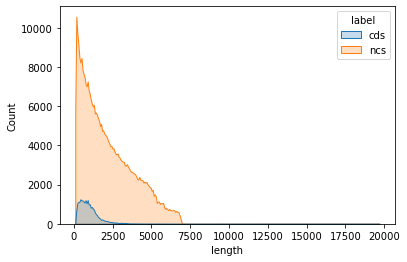

In [4]:
preprocess.plot_data_distributions(_cds, _ncs, x='length')

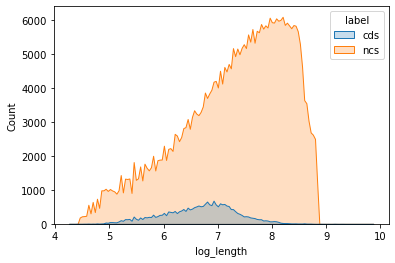

In [5]:
preprocess.plot_data_distributions(_cds, _ncs, x='log_length')

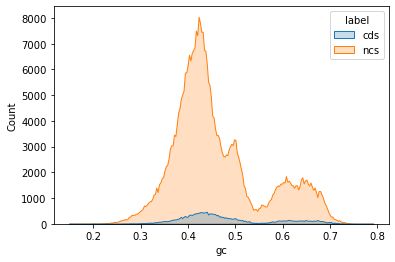

In [6]:
preprocess.plot_data_distributions(_cds, _ncs, x='gc')

### SeqRecord Structure

The CDS and NCS data are lists of Biopython **SeqRecord** that contain information about each sequence, such as `ID`, `Name`, `Description`, `Number of features`, and `Seq`.

* `ID` is the GenBank accession number for the prokaryotic genome the sequence was extracted from. 
* `Name` is a auto-generated identifier that the program creates for each sequence. 
* `Description` is blank. 
* `Number of features` includes another Biopython data structure called **SeqFeature** that contains information about the type (CDS or NCS), start location on the genome, the stop location on the genome, and what strand the gene originated from - (+) if it came from the template strand and (-) if it came from the coding strand. 
* `Seq` is another Biopython object that contains the sequence of the gene. 

**NOTE**: the sequence contains a buffer of *30 basepairs upstream of the start codon* and *30 basepairs downstream of the stop codon*. The additional information is necessary to extract the TIS feature.

In [7]:
# example of cds SeqRecord
example_record = _cds[0]

print(example_record.id)
print(example_record.name)
print(example_record.description)
print(example_record.features[0])
print(example_record.seq[30:-30])

NC_000917
AF_RS00005
<unknown description>
type: CDS
location: [4289:4784](+)
qualifiers:

ATGAAAGAGACGATTCAGCTTGCTATAGGGGTGATGCTGTTGGCCATGCTCGGTTGCTACATCTACATTACTGAGTTCTATCACTACGAATCAACTGAAGAGAGCTCAAAAGCTGCGATTGAATATTTGAATCAGCTTAGAGCTCAGAATGGCCTGCCTCCTGTAAAGTGGAATAAAACTCTTTACGAGTTTGCGCTGGAAAGGCTTGAAGATATGCATGAAAGAGGCTATTACAGTCATTATGACCCTGTTACGCATGAGACGCTGATTTACAGATATGTTGAGGGGTATGTTGGAGAGTGTATCTTGAATGGTGTAAGAGGTACAAATCTTCTCTCCAATGGGCTTCAGTCATTATTTGGCTATGAAGAAGAAGCTATAGATATCTGGTCTAAAAGCACCATGCACAAACTCATTCTCACTGATAAACGCTTCACAGATGCCGCTGTAGCCTGCAAGTACGACATGTGTGTTTTGATTATGACGGGTGGTTGA


### Shuffle and Split Training Data

Training data is split into two datasets - one to train the linear discriminant weight vectors and one to train the neural network.

In [8]:
# merge CDS and NCS data
_seq = _cds + _ncs

# shuffle and split data
LD_Data, NN_Data = genepred.split_training_records(_seq, size=0.5, \
                                                   random_state=SEED, \
                                                   shuffle=True)

In [9]:
print(f'LD Dataset: {len(LD_Data)}')
print(f'NN Dataset: {len(NN_Data)}')

LD Dataset: 189566
NN Dataset: 189566


In [10]:
# save records as FASTA file
predict.seqrecord2fasta(filename='./input/train_8g.fna', seq_records=_seq)

Saved genome fragments to ./input/train_8g.fna.


## Train Linear Discriminant Weight Vectors for Dimensional Reduction

### Extract Features - Monocodon (Tri), Dicodon (Hex), TIS

Common meaningful features that are extracted from a genome include the `codon frequency` (monocodon or tri), the `dicodon frequency` (dicodon or hex), the `translation initiation sites` (TIS), and `GC content`. For training the linear discriminant, only the first three features will be extracted since they are highly dimensional. 
* Codon Frequency - ex. ATGCCC... => 'ATG', 'CCC', ...
* Dicodon Frequency - ex. ATGCCCTTT... => 'ATGCCC', 'CCCTTT', ...
* TIS - frame that includes 30 basepairs (bp) upstream and downstream of start codons

**Note:** TIS features are different for discriminant training vs NN training. For discriminant training, TIS features are from CDS only - a TIS frame starting at the true start codon is positive; a TIS frame starting at a start codon within the gene is negative. See the `Hoff et al.` paper for more information on features.

Input arguments for `extract.training_features`
* **seq_records** - list of linear discriminant SeqRecords
* **OFFSET** - default `=30`

Return types for `extract.training_features`
* **cod_feat** - codon features (monocodon, dicodon)
* **cod_y** - labels for codon features
* **tis_feat** - training tis features
* **tis_y** - labels for training tis features

In [11]:
%time cod_feat, cod_y, tis_feat, tis_y = extract.training_features(LD_Data, OFFSET=30)

CPU times: user 12min 10s, sys: 45.9 s, total: 12min 56s
Wall time: 13min


### Train Discriminant Weight Vectors

We need to minimize:

$$ E(w_M) = \frac{1}{n}\sum_{i=0}^{n}(w_m \cdot x_M^i - y_i)^2 + \lambda w_M \cdot w_M $$

where $x_M^i \in \mathbb{R}^{64}$ is the $i-th$ column of the monocodon frequency matrix $\textbf{X}_M$, $n=64$ monocodon possibilities, $y_M^i \in (-1, 1)$ is the $i-th$ element of the label vector, and $w_M$ is the discriminant weight vector.

We can minimize $E$ by:

$$w_M = (X_MX_M^T +\lambda n\textbf{I})^{-1}X_My_M$$

This can be generalized to train the discriminant vector $w$ for dicodon frequency and TIS. 

In [12]:
wM = train.discriminant(cod_feat[0], cod_y)
wD = train.discriminant(cod_feat[1], cod_y)
wT = train.discriminant(tis_feat,    tis_y)
w = [wM, wD, wT]

In [13]:
print(f'Weights Shape: wM {w[0].shape}, wD {w[1].shape}, wT {w[2].shape}')

Weights Shape: wM (64,), wD (4096,), wT (3712,)


### Train TIS Gaussian Parameters 

Ideally, input sequences into the prediction algorithm will contain all the information we need to determine if the sequence is a gene or not. However, next-generation sequencing (NGS) tools often produce fragments of DNA that vary in length from 100 bp to 700 bp. Therefore, the entire TIS region (30 bp upstream of the start codon to 30 bp downstream of the start codon) may not be present in the input sequence. 

To overcome this, a Gaussian distribution can be trained on the training genomes provided. Then, we can predict how likely a given fragment of a TIS window is from a gene or not.

In [14]:
%time p = train.tis_gaussian(tis_feat, tis_y, wT)

CPU times: user 15.7 s, sys: 2min 2s, total: 2min 18s
Wall time: 3min 3s


In [15]:
print(f'Pos (pi, mu, sd): {round(p[0][0],4)}, {round(p[1][0],4)}, {round(p[2][0],4)}')
print(f'Neg (pi, mu, sd): {round(p[0][1],4)}, {round(p[1][1],4)}, {round(p[2][1],4)}')

Pos (pi, mu, sd): 0.035, -0.0818, 0.672
Neg (pi, mu, sd): 0.965, -0.9608, 0.1344


### Visualize TIS Weight Vector

<AxesSubplot:>

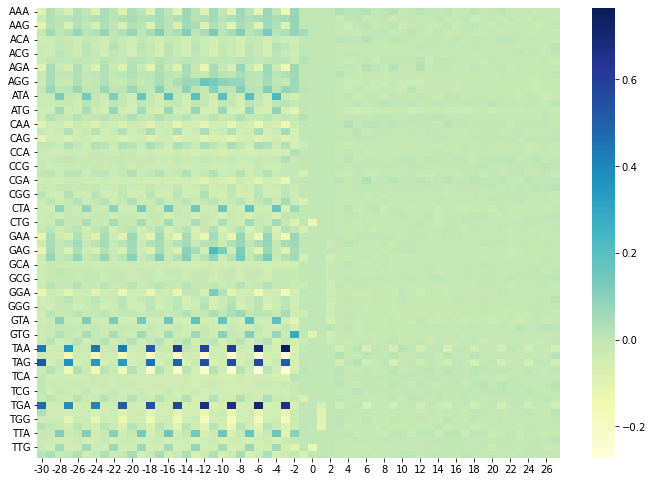

In [16]:
from modules.extract import populate_codon_idx_dict

tis_weights = np.array(w[2]).reshape(58,64).T

y_axis_labels = populate_codon_idx_dict(nbases=3).keys()
x_axis_labels = [i for i in range(-30,28)]

df = pd.DataFrame(tis_weights, columns=x_axis_labels, index=y_axis_labels)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df, cmap="YlGnBu")

## Train Binary Classification Neural Network

In [ ]:
# load latest parameters
w, p = genepred.load_param("./model/param_8g.csv")

In [17]:
# suppress tf messages/warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Extract Features

Return types for `extract.features`
* **features** - all features (monocodon, dicodon, tis, gc)
* **y** - labels for features

In [20]:
%time NN_features, NN_y = extract.features(NN_Data)

CPU times: user 11min 23s, sys: 1min 44s, total: 13min 7s
Wall time: 13min 12s


In [21]:
print(f'({len(NN_features[0])},{len(NN_features)})')
print(f'({len(NN_y)},)')

(189134,4)
(189134,)


### Dimensionally Reduce Large Features

Return types for `extract.dimensional_reduction`
* **nn_input** - (n,5) matrix of reduced features

Features include:
* x1 = reduced monocodon frequency
* x2 = reduced dicodon frequency
* x3 = positive tis score (gaussian probability)
* x4 = negative tis score (gaussian probability)
* x7 = gc content

In [22]:
%time nn_input = extract.dimentional_reduction(NN_features, w, p)

CPU times: user 25 s, sys: 2min 21s, total: 2min 46s
Wall time: 3min 7s


In [23]:
print(f'({len(nn_input)}, {len(nn_input[0])})')

(189134, 5)


### Test, Train, Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(nn_input, np.array(NN_y), test_size=0.2, random_state=SEED)

In [25]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(151307, 5) (151307,)
(37827, 5) (37827,)


### Define Neural Network Model

In [26]:
model = Sequential()
model.add(Dense(25, input_dim=5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


### Train Neural Network

In [28]:
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
2365/2365 [==============================] - 5s 2ms/step - loss: 0.2749 - accuracy: 0.8914
Epoch 2/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1980 - accuracy: 0.9389
Epoch 3/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1944 - accuracy: 0.9401
Epoch 4/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1909 - accuracy: 0.9409
Epoch 5/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1917 - accuracy: 0.9406
Epoch 6/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1904 - accuracy: 0.9410
Epoch 7/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1908 - accuracy: 0.9407
Epoch 8/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1903 - accuracy: 0.9407
Epoch 9/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1917 - accuracy: 0.9403
Epoch 10/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.187

### Evaluate Model

In [29]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 94.26%


Confusion matrix, without normalization
[[35350   140]
 [ 2030   307]]


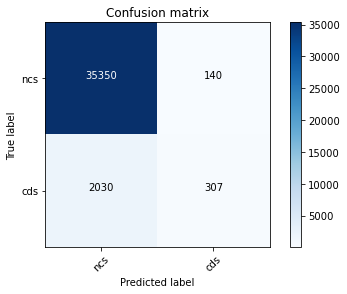

In [30]:
# make predictions
predictions = model.predict(X_test)

# convert predictions to 1 or 0
y_pred = [1 if val >= 0.5 else 0 for val in predictions]

# create confusion matrix
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
genepred.plot_confusion_matrix(cm=cm, classes=['ncs','cds'], normalize=False)

In [37]:
TPR = 307 / (307+140)
FPR = 1 - (35350 / (35350+2030))
print(f'{round(TPR,3)}, {round(FPR,3)}')

0.687, 0.054


## Save

In [31]:
# save NN model as JSON/H5
genepred.save_model2json("./model/model_8g", model)

Saved model to disk.


In [32]:
# save weights and TIS Gaussian parameters
data = w + p
genepred.save_params2csv("./model/param_8g.csv", data)

Saved data to disk.


# Gene Prediction

## How to use Gene Prediction Tools

### Option 1: Use the Built-In `.predict` Method

In [102]:
data = genepred.load_params("./model/param_4g.csv")
w, p = data[0:3], data[3:]

Loaded parameters from disk.


In [103]:
# test first 5 cds records - extract features + dim red
op1_records = _cds[0:5]
op1_feat, op1_y = extract.features(op1_records)
op1_red_feat = extract.dimentional_reduction(op1_feat, w, p)

In [104]:
# predictions + convert to 1s and 0s
pp = model.predict(op1_red_feat)
pp = [1 if val >= 0.5 else 0 for val in pp]

In [106]:
pp

[1, 1, 1, 1, 1]

### Option 2: Extract Sequences from GenBank Genome

The `predict.from_genome` method extracts sequences from input genomes (txt file of accession numbers), creates a temporary FASTA file in the `./input` folder called `tmp.fna` that contains all extracted sequences in the FASTA format, and creates an output prediction file with the sequences that it predicted as genes.

In [ ]:
gb_file = './input/train.txt'      # txt file of genbank accession numbers
num = 1                            # number of genomes to extract from input txt file
seq = 'cds'                        # only getting CDS sequences 

par = './model/param_4g.csv'       # saved csv of parameter values (w, p)
mod = './model/model_4g'           # saved json/h5 of NN model
out = './results/gb_pred_test.fna' # location of prediction results

In [ ]:
%time pg = predict.from_genome(filename=gb_file, \
                               n_genomes=num, \
                               params=par, \
                               model=mod, \
                               outfile=out, \
                               seq=seq)

In [ ]:
# create confusion matrix
y_true_op2 = [1]*len(pg)
cm_op2 = metrics.confusion_matrix(y_true=y_true_op2, y_pred=pg)

# plot confusion matrix
genepred.plot_confusion_matrix(cm=cm_op2, classes=['ncs','cds'], normalize=False)

### Option 3: Input FASTA File Containing Sequences

Using `tmp.fna` file created from the `predict.from_genome` method above as the example input.

In [ ]:
fna_file = './input/tmp.fna'          # input fasta file

par = './model/param_4g.csv'          # saved csv of parameter values (w, p)
mod = './model/model_4g'              # saved json/h5 of NN model
out = './results/fasta_pred_test.fna' # location of prediction results

In [ ]:
% time pf = predict.from_fasta(filename=fna_file, \
                               params=par, \
                               model=mod, \
                               outfile=out)

In [ ]:
# create confusion matrix
y_true_op3 = [1]*len(pf)
cm_op3 = metrics.confusion_matrix(y_true=y_true_op2, y_pred=pg)

# plot confusion matrix
genepred.plot_confusion_matrix(cm=cm_op3, classes=['ncs','cds'], normalize=False)

## Input your sequences for prediction